# Filtering Using Anipose

The strategy is to:
- Select a subset of frames to filter
- triangulate the frames in a vanilla way to use as baseline
- apply anipose to the frames to filter
- compare the two sets of points to see how much they differ


In [7]:
# import packages
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import multicam_calibration.geometry as mcc_geom
import numpy as np
import pandas as pd
import xarray as xr
from movement.io.load_poses import from_numpy
from threed_utils.io import movement_ds_from_anipose_triangulation_df, read_calibration_toml
from threed_utils.anipose.triangulate import CameraGroup, triangulate_core
import re
from movement.io.load_poses import from_file

In [53]:
# get arena views 3d 
arena_3d = xr.load_dataset('/Users/thomasbush/Documents/Vault/Iurilli_lab/3d_tracking/3d-setup/tests/assets/arena_views_triangulated.h5')

## Load data

- Load calibration data
- Load video data

In [5]:
data_dir = Path("/Users/thomasbush/Documents/Vault/Iurilli_lab/3d_tracking/data/calibration")
# Read checkerboard detections as movement dataset

# Load last available calibration among mc_calibrarion_output_*
calibration_paths = sorted(data_dir.glob("mc_calibration_output_*"))
last_calibration_path = calibration_paths[-1]

all_calib_uvs = np.load(last_calibration_path / "all_calib_uvs.npy")
calib_toml_path = last_calibration_path / "calibration_from_mc.toml"
cam_names, img_sizes, extrinsics, intrinsics = read_calibration_toml(calib_toml_path)

In [8]:
slp_files_dir = Path('/Users/thomasbush/Documents/Vault/Iurilli_lab/3d_tracking/data/video_test')
slp_files = list(slp_files_dir.glob("*.slp"))
cam_regex = r"multicam_video_\d{4}-\d{2}-\d{2}T\d{2}_\d{2}_\d{2}_([^_]+)_predictions\.slp$"

In [9]:
file_path_dict = {re.search(cam_regex, str(f.name)).groups()[0]: f for f in slp_files}
# From movement.io.load_poses.from_multiview_files, split out here just to fix uppercase inconsistency bug:
views_list = list(file_path_dict.keys())
new_coord_views = xr.DataArray(views_list, dims="view")

dataset_list = [
    from_file(f, source_software="SLEAP")
    for f in file_path_dict.values()
]
# make coordinates labels of the keypoints axis all lowercase
for ds in dataset_list:
    ds.coords["keypoints"] = ds.coords["keypoints"].str.lower()

time_slice = slice(0, 1000)
ds = xr.concat(dataset_list, dim=new_coord_views).sel(time=time_slice)

bodyparts = list(ds.coords["keypoints"].values)

## Triangulate the frames

In [49]:
def mcc_triangulate_ds(
    xarray_dataset, calib_toml_path, progress_bar=True
):
    cam_names, _, extrinsics, intrinsics = read_calibration_toml(calib_toml_path)

    positions = xarray_dataset.position
    confidence = xarray_dataset.confidence  # TODO implement confidence propagation

    # use cam_names to sort the view axis, after having checked that the views are the same:
    print(xarray_dataset.coords["view"].values, cam_names)
    assert set(xarray_dataset.coords["view"].values) == set(cam_names), "Views do not match: " + str(list(positions.coords["view"])) + " vs " + str(cam_names)
    positions = positions.sel(view=cam_names)
    print(positions.coords["view"].values)
    
    # get first individual, regarless of its name:
    positions = positions.sel(individuals=positions.coords["individuals"][0], drop=True)

    # enforce order:
    positions = positions.transpose("view", "time", "keypoints", "space").values
    all_triang = []
    for i in tqdm(range(len(xarray_dataset.coords["keypoints"])), "Triangulating keypoints: ", 
                  disable=not progress_bar):
        triang = mcc_geom.triangulate(positions[:, :, i, :], extrinsics, intrinsics)
        all_triang.append(triang)

    threed_coords = np.array(all_triang)  # shape n_keypoints, n_frames, 3
    # reshape to n_frames, 1, n_keypoints, 3
    threed_coords = threed_coords.transpose(1, 0, 2)[:, np.newaxis, :, :]
    # TODO propagate confidence smartly
    confidence_array = np.ones(threed_coords.shape[:-1])
    #change again shape to match anipose:
    print(threed_coords.shape, confidence_array.shape)
    threed_coords = threed_coords.transpose(0, 3, 2, 1)
    confidence_array = confidence_array.transpose(0, 2, 1)
    

    return from_numpy(position_array=threed_coords,
               confidence_array=confidence_array,
               individual_names=xarray_dataset.coords["individuals"].values,
               keypoint_names=xarray_dataset.coords["keypoints"].values,
               source_software=xarray_dataset.attrs["source_software"] + "_triangulated",
               )



In [77]:
# function to triangulate the frames
def anipose_triangulate_ds(views_ds, calib_toml_path, **config_kwargs):
    triang_config = config_kwargs
    config = dict(triangulation=triang_config)

    calib_fname = str(calib_toml_path)
    cgroup = CameraGroup.load(calib_fname)
    # read toml file and use the views to order the dimenensions of the views_ds, so thne you are sure that when you will do the back projeciton thsoe are the same order of the matrices.
    print(cgroup.get_names(), views_ds.coords["view"].values)
    individual_name = views_ds.coords["individuals"][0]
    reshaped_ds = views_ds.sel(individuals=individual_name, time=slice(0, 1000)).transpose("view", "time", "keypoints", "space")
    # sort over view axis using the view ordring
    positions = reshaped_ds.position.values
    scores = reshaped_ds.confidence.values
    # TODO: add sorting dimension  form the toml file to 

    triang_df = triangulate_core(config, 
                 positions, 
                 scores, 
                 views_ds.coords["keypoints"].values, 
                 cgroup, 
                 )
    print(triang_df.info)
    return movement_ds_from_anipose_triangulation_df(triang_df)

In [80]:
def anipose_triangulate_ds(views_ds, calib_toml_path, **config_kwargs):
    triang_config = config_kwargs
    config = dict(triangulation=triang_config)

    calib_fname = str(calib_toml_path)
    cgroup = CameraGroup.load(calib_fname)
    
    # Get camera names from calibration group
    cam_names = cgroup.get_names()
    print("Camera names from calibration:", cam_names)
    print("Current view order:", views_ds.coords["view"].values)
    
    # Verify that the views match
    assert set(views_ds.coords["view"].values) == set(cam_names), \
        f"Views do not match: {list(views_ds.coords['view'].values)} vs {cam_names}"
    
    individual_name = views_ds.coords["individuals"][0]
    # Sort the views dimension according to calibration camera order
    reshaped_ds = views_ds.sel(
        individuals=individual_name, 
        time=slice(0, 1000)
    ).sel(view=cam_names).transpose("view", "time", "keypoints", "space")
    
    positions = reshaped_ds.position.values
    scores = reshaped_ds.confidence.values

    triang_df = triangulate_core(config, 
                 positions, 
                 scores, 
                 views_ds.coords["keypoints"].values, 
                 cgroup, 
                 )
    print(triang_df.info)
    return movement_ds_from_anipose_triangulation_df(triang_df)

In [61]:


calib_fname = str(calib_toml_path)
cgroup = CameraGroup.load(calib_fname)
# read toml file and use the views to order the dimenensions of the views_ds, so thne you are sure that when you will do the back projeciton thsoe are the same order of the matrices.


In [64]:
individual_name = ds.coords["individuals"][0]
reshaped_ds = ds.sel(individuals=individual_name, time=slice(0, 1000)).transpose("view", "time", "keypoints", "space")
# sort over view axis using the view ordring
positions = reshaped_ds.position.values
scores = reshaped_ds.confidence.values


In [69]:
positions.shape

(5, 1001, 13, 2)

In [50]:
mcc_triangulated_ds = mcc_triangulate_ds(ds, calib_toml_path)

['mirror-bottom' 'mirror-right' 'mirror-left' 'mirror-top' 'central'] ['mirror-top', 'mirror-bottom', 'mirror-right', 'mirror-left', 'central']
['mirror-top' 'mirror-bottom' 'mirror-right' 'mirror-left' 'central']


Triangulating keypoints: 100%|██████████| 13/13 [00:00<00:00, 13.36it/s]

(1001, 1, 13, 3) (1001, 1, 13)


In [87]:

triang_config_optim = {
    "ransac": True,
    "optim": True,
    "optim_chunking": True,
    "optim_chunking_size": 100,
    "score_threshold": 0.8,
    "scale_smooth": 2,  # Increase smoothing
    "scale_length": 4,  # Enforce stronger length constraints
    "scale_length_weak": 0.5,
    "n_deriv_smooth": 3,
    "reproj_error_threshold": 100,  # Stricter threshold
    "constraints": [
        ['lear', 'rear'],  # Stabilize critical distances
        ['rear', 'nose'],
        ['lear', 'nose'], 
        ['upperback', 'uppermid'],
        ['uppermid', 'upperforward'],
        ['upperback', 'tailbase']
    ],
    "constraints_weak": [],
}



anipose_triangulated_ds_optim = anipose_triangulate_ds(ds, 
                                                       calib_toml_path, 
                                                       **triang_config_optim)

Camera names from calibration: ['mirror-top', 'mirror-bottom', 'mirror-right', 'mirror-left', 'central']
Current view order: ['mirror-bottom' 'mirror-right' 'mirror-left' 'mirror-top' 'central']


  0%|                                       | 0/13013 [00:00<?, ?it/s]

100%|██████████████████████████| 13013/13013 [01:02<00:00, 209.17it/s]


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.8957e+07                                    2.28e+06    
       1              2         8.5175e+06      4.04e+07       8.42e+02       1.15e+06    
       2              3         1.1912e+06      7.33e+06       2.08e+02       3.68e+05    
       3              4         6.7393e+05      5.17e+05       5.81e+01       3.73e+05    
       4              5         2.1568e+05      4.58e+05       2.71e+01       9.29e+04    
       5              6         1.5580e+05      5.99e+04       1.07e+01       1.13e+04    
       6              7         1.5412e+05      1.68e+03       4.48e+00       1.02e+03    
       7              8         1.5408e+05      3.79e+01       2.94e+00       3.23e+02    
`ftol` termination condition is satisfied.
Function evaluations 8, initial cost 4.8957e+07, final cost 1.5408e+05, first-order optimality 3.23e+02.
optimization took 0.62 seconds
  

In [88]:
anipose_triangulated_ds_optim.attrs['fps'] = 'fps'
anipose_triangulated_ds_optim.attrs['source_file'] = 'anipose'
anipose_triangulated_ds_optim.to_netcdf(slp_files_dir / "anipose_triangulated_ds_optimised_extra.h5")

## Metrics for Distance Analysis

In [95]:
def analyze_keypoint_distances(ds, keypoint1, keypoint2, verbose=True):
    """
    Calculate frame-by-frame distances between two keypoints and analyze variation,
    with better handling of NaN values
    """
    # Extract 3D positions for both keypoints
    pos1 = ds.position.sel(keypoints=keypoint1).values
    pos2 = ds.position.sel(keypoints=keypoint2).values
    
    if verbose:
        print(f"Shape of position arrays: {pos1.shape}, {pos2.shape}")
        print(f"Number of NaN values in pos1: {np.isnan(pos1).sum()}")
        print(f"Number of NaN values in pos2: {np.isnan(pos2).sum()}")
    
    # Calculate Euclidean distance for each frame
    distances = np.sqrt(np.sum((pos1 - pos2)**2, axis=1))
    
    if verbose:
        print(f"Number of NaN distances: {np.isnan(distances).sum()}")
        print(f"Total number of frames: {len(distances)}")
    
    # Calculate statistics using nan-aware functions
    valid_distances = distances[~np.isnan(distances)]
    
    if len(valid_distances) == 0:
        print("Warning: No valid distances found!")
        return distances, {}
    
    stats = {
        'mean_distance': np.nanmean(distances),
        'std_distance': np.nanstd(distances),
        'min_distance': np.nanmin(distances),
        'max_distance': np.nanmax(distances),
        'coefficient_of_variation': np.nanstd(distances) / np.nanmean(distances) * 100,
        'valid_frames': len(valid_distances),
        'total_frames': len(distances),
        'percent_valid': (len(valid_distances) / len(distances)) * 100
    }
    
    return distances, stats

Shape of position arrays: (1001, 3, 1), (1001, 3, 1)
Number of NaN values in pos1: 36
Number of NaN values in pos2: 0
Number of NaN distances: 12
Total number of frames: 1001
Distance statistics between lear and rear:
mean_distance: 26.72
std_distance: 4.36
min_distance: 3.68
max_distance: 40.43
coefficient_of_variation: 16.30
valid_frames: 989.00
total_frames: 1001.00
percent_valid: 98.80


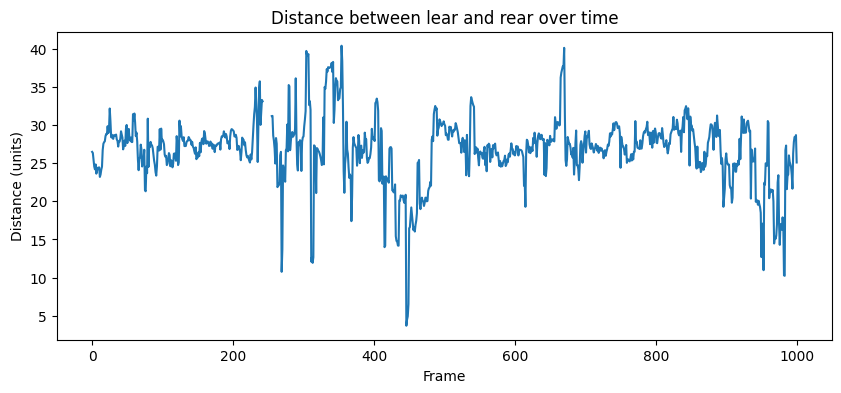

In [115]:
distances, stats = analyze_keypoint_distances(mcc_triangulated_ds, 'nose', 'lear')

print("Distance statistics between lear and rear:")
for metric, value in stats.items():
    print(f"{metric}: {value:.2f}")

# Optional: Plot the distances over time
plt.figure(figsize=(10, 4))
plt.plot(distances)
plt.title('Distance between lear and rear over time')
plt.xlabel('Frame')
plt.ylabel('Distance (units)')
plt.show()

Shape of position arrays: (1001, 3, 1), (1001, 3, 1)
Number of NaN values in pos1: 0
Number of NaN values in pos2: 0
Number of NaN distances: 0
Total number of frames: 1001
Distance statistics between lear and rear:
mean_distance: 26.20
std_distance: 0.09
min_distance: 25.91
max_distance: 26.48
coefficient_of_variation: 0.36
valid_frames: 1001.00
total_frames: 1001.00
percent_valid: 100.00


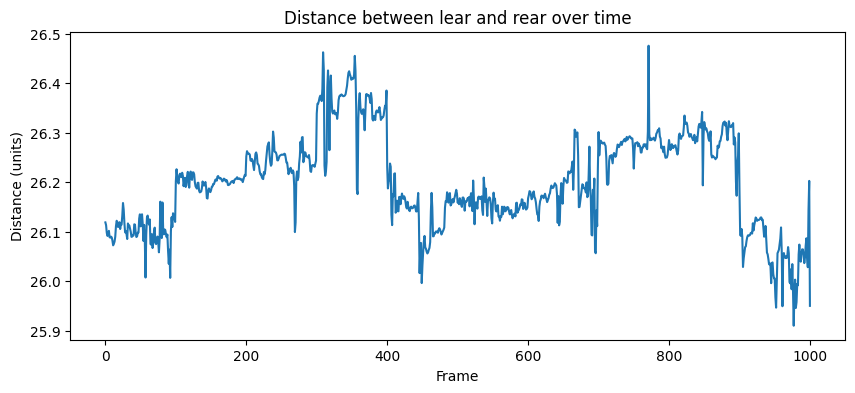

In [116]:


distances_optimesed, stats = analyze_keypoint_distances(anipose_triangulated_ds_optim, 'nose', 'lear')

print("Distance statistics between lear and rear:")
for metric, value in stats.items():
    print(f"{metric}: {value:.2f}")

# Optional: Plot the distances over time
plt.figure(figsize=(10, 4))
plt.plot(distances_optimesed)
plt.title('Distance between lear and rear over time')
plt.xlabel('Frame')
plt.ylabel('Distance (units)')
plt.show()

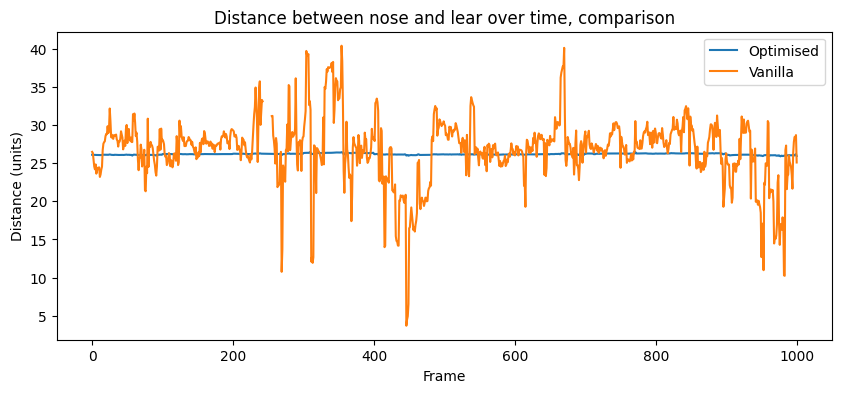

In [117]:
plt.figure(figsize=(10, 4))
plt.plot(distances_optimesed, label='Optimised')
plt.plot(distances, label='Vanilla')
plt.title('Distance between nose and lear over time, comparison')
plt.legend(['Optimised', 'Vanilla'])
plt.xlabel('Frame')
plt.ylabel('Distance (units)')
plt.show()

Shape of position array: (1001, 3, 1)
Number of NaN values: 0
Shape of position array: (1001, 3, 1)
Number of NaN values: 0


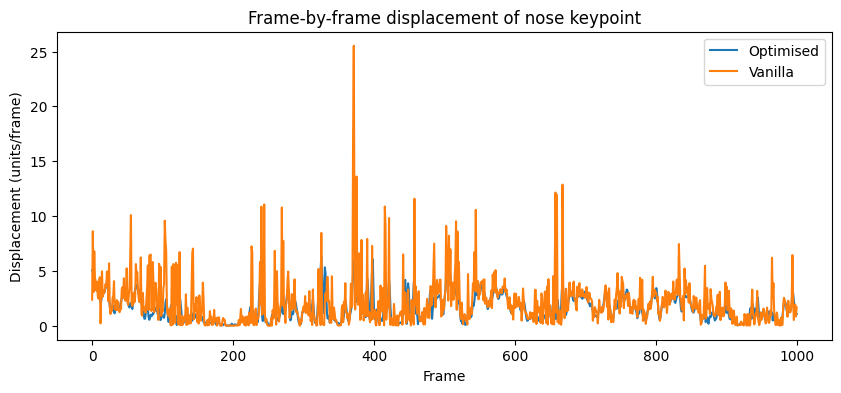

In [106]:
def analyze_keypoint_movement(ds, keypoint, verbose=True):
    """
    Calculate frame-by-frame movement (displacement) of a single keypoint
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Dataset containing position data
    keypoint : str
        Name of the keypoint to analyze
    verbose : bool
        Whether to print additional information
        
    Returns:
    --------
    displacements : numpy.ndarray
        Array of frame-by-frame displacements
    stats : dict
        Dictionary containing movement statistics
    """
    # Extract 3D positions for the keypoint
    positions = ds.position.sel(keypoints=keypoint).values
    
    if verbose:
        print(f"Shape of position array: {positions.shape}")
        print(f"Number of NaN values: {np.isnan(positions).sum()}")
    
    # Calculate displacement between consecutive frames
    displacements = np.sqrt(np.sum((positions[1:] - positions[:-1])**2, axis=1))
    
    # Calculate statistics
    stats = {
        'mean_displacement': np.nanmean(displacements),
        'std_displacement': np.nanstd(displacements),
        'min_displacement': np.nanmin(displacements),
        'max_displacement': np.nanmax(displacements),
        'total_distance': np.nansum(displacements),
        'valid_frames': np.sum(~np.isnan(displacements)),
        'total_frames': len(displacements)
    }
    
    return displacements, stats

# Example usage:
# Compare movement of 'nose' between vanilla and optimized triangulation
vanilla_displacements, vanilla_stats = analyze_keypoint_movement(mcc_triangulated_ds, 'tailbase')
optimized_displacements, optimized_stats = analyze_keypoint_movement(anipose_triangulated_ds_optim, 'tailbase')

# Plot comparison
plt.figure(figsize=(10, 4))
plt.plot(optimized_displacements, label='Optimised')
plt.plot(vanilla_displacements, label='Vanilla')
plt.title('Frame-by-frame displacement of nose keypoint')
plt.legend()
plt.xlabel('Frame')
plt.ylabel('Displacement (units/frame)')
plt.show()

Shape of position array: (1001, 3, 1)
Number of NaN values: 36
Shape of position array: (1001, 3, 1)
Number of NaN values: 0


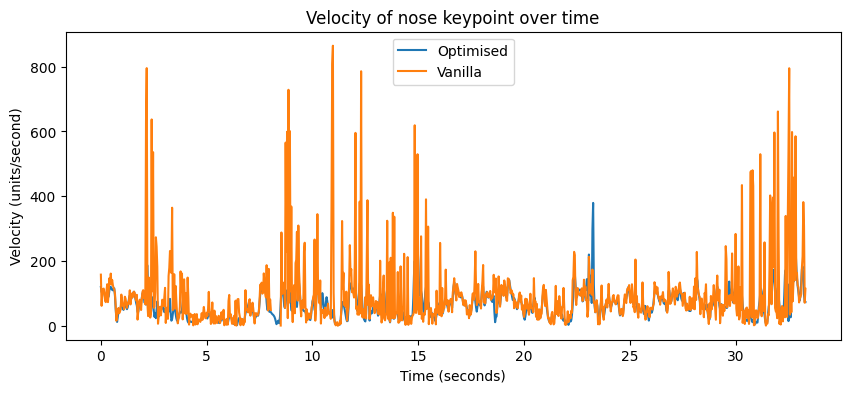

In [108]:
def analyze_keypoint_movement(ds, keypoint, fps=30, verbose=True):
    """
    Calculate movement (displacement) of a single keypoint in seconds
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Dataset containing position data
    keypoint : str
        Name of the keypoint to analyze
    fps : float
        Frames per second of the recording (default: 30)
    verbose : bool
        Whether to print additional information
        
    Returns:
    --------
    displacements : numpy.ndarray
        Array of displacements in units/second
    stats : dict
        Dictionary containing movement statistics
    """
    # Extract 3D positions for the keypoint
    positions = ds.position.sel(keypoints=keypoint).values
    
    if verbose:
        print(f"Shape of position array: {positions.shape}")
        print(f"Number of NaN values: {np.isnan(positions).sum()}")
    
    # Calculate displacement between consecutive frames
    frame_displacements = np.sqrt(np.sum((positions[1:] - positions[:-1])**2, axis=1))
    
    # Convert to units/second
    displacements = frame_displacements * fps
    
    # Calculate statistics
    stats = {
        'mean_velocity': np.nanmean(displacements),  # units/second
        'std_velocity': np.nanstd(displacements),
        'min_velocity': np.nanmin(displacements),
        'max_velocity': np.nanmax(displacements),
        'total_distance': np.nansum(frame_displacements),  # total distance in units
        'duration_seconds': len(frame_displacements) / fps,  # total time in seconds
        'average_speed': np.nansum(frame_displacements) / (len(frame_displacements) / fps),  # units/second
        'valid_frames': np.sum(~np.isnan(displacements)),
        'total_frames': len(displacements)
    }
    
    return displacements, stats

# Example usage:
vanilla_velocities, vanilla_stats = analyze_keypoint_movement(mcc_triangulated_ds, 'nose', fps=30)
optimized_velocities, optimized_stats = analyze_keypoint_movement(anipose_triangulated_ds_optim, 'nose', fps=30)

# Plot comparison
plt.figure(figsize=(10, 4))
plt.plot(np.arange(len(optimized_velocities))/30, optimized_velocities, label='Optimised')
plt.plot(np.arange(len(vanilla_velocities))/30, vanilla_velocities, label='Vanilla')
plt.title('Velocity of nose keypoint over time')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('Velocity (units/second)')
plt.show()

Shape of position array: (1001, 3, 1)
Number of NaN values: 30
Shape of position array: (1001, 3, 1)
Number of NaN values: 0


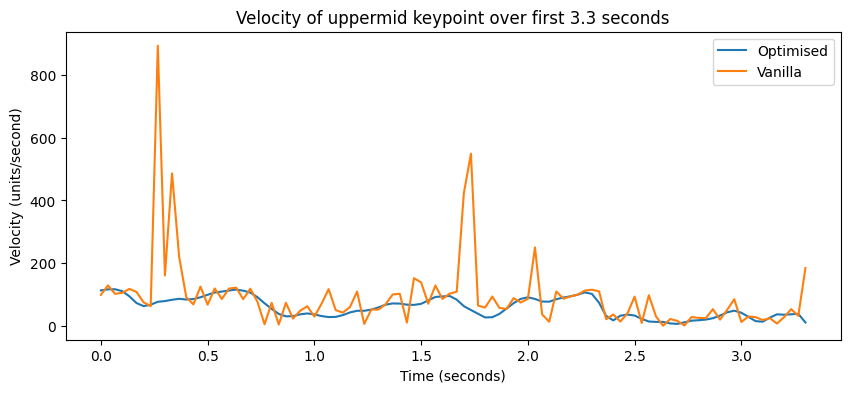

In [114]:
# Example usage with 100 frame limit
frames_to_show = 100
time_to_show = frames_to_show / 30  # convert frames to seconds

vanilla_velocities, vanilla_stats = analyze_keypoint_movement(mcc_triangulated_ds, 'uppermid', fps=30)
optimized_velocities, optimized_stats = analyze_keypoint_movement(anipose_triangulated_ds_optim, 'uppermid', fps=30)

# Plot comparison
plt.figure(figsize=(10, 4))
plt.plot(np.arange(frames_to_show)/30, optimized_velocities[:frames_to_show], label='Optimised')
plt.plot(np.arange(frames_to_show)/30, vanilla_velocities[:frames_to_show], label='Vanilla')
plt.title(f'Velocity of uppermid keypoint over first {time_to_show:.1f} seconds')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('Velocity (units/second)')
plt.show()

Shape of position arrays: (1001, 3, 1), (1001, 3, 1)
Number of NaN values in pos1: 36
Number of NaN values in pos2: 0
Number of NaN distances: 12
Total number of frames: 1001
Shape of position arrays: (1001, 3, 1), (1001, 3, 1)
Number of NaN values in pos1: 0
Number of NaN values in pos2: 0
Number of NaN distances: 0
Total number of frames: 1001


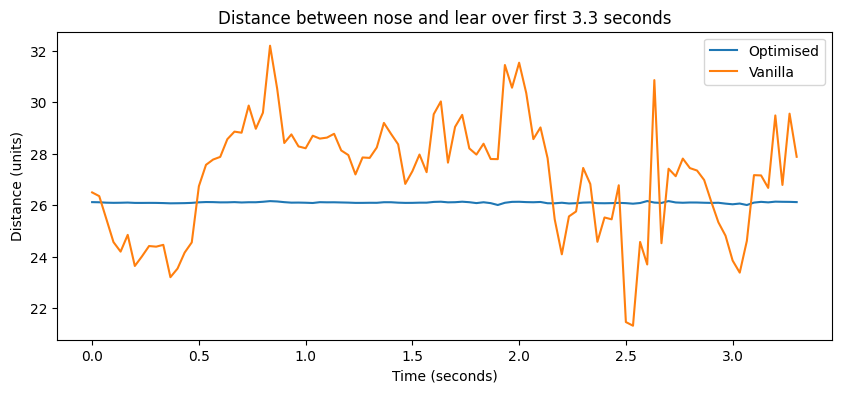

In [113]:
# Set the display limit
frames_to_show = 100
time_to_show = frames_to_show / 30  # convert frames to seconds

# Get distances between upperback and tailbase for both methods
distances_vanilla, stats_vanilla = analyze_keypoint_distances(mcc_triangulated_ds, 'nose', 'lear')
distances_optimized, stats_optimized = analyze_keypoint_distances(anipose_triangulated_ds_optim, 'nose', 'lear')

# Plot comparison with time limit
plt.figure(figsize=(10, 4))
plt.plot(np.arange(frames_to_show)/30, distances_optimized[:frames_to_show], label='Optimised')
plt.plot(np.arange(frames_to_show)/30, distances_vanilla[:frames_to_show], label='Vanilla')
plt.title(f'Distance between nose and lear over first {time_to_show:.1f} seconds')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('Distance (units)')
plt.show()